# Sentiment Analysis Model Jupyter Notebook

_Giorgio Bakhiet Derias_
_I3a, Bachelorarbeit_

The aim of this notebook is to show the process of creating a sentiment analysis model which reads text input and is able to attribute an emotion to it.
To train the model, I use several different datasets.

## Setup
These are the required python libraries that are used in sentiment analysis.

### Install from requirements
In order to work I first need to install the libraries from which I will then import what I need.
Since I moved my work from a Colab file to here, I created a text file called *requirements*, in which I saved all the libraries I used.
The usefulness of this file is when I move to a new environment, installing all packages at once by simply typing:

In [3]:
#%conda install --file requirements.txt

Check whether packages need updates:

In [4]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 7.1 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4


### Installing other libraries

In [5]:
!pip install -q tensorflow-text
!pip install gdown
!pip install -q tf-models-official
!pip install tensorflow-gpu
!pip install transformers
!pip install plotly-express
!pip install tidypython
!pip3 install ktrain
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

distutils: /home/mlmp/conda/include/python3.8/UNKNOWN
sysconfig: /home/mlmp/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /home/mlmp/conda/include/python3.8/UNKNOWN
sysconfig: /home/mlmp/conda/include/python3.8
user = False
home = None
root = None
prefix = None


## Imports
Once installed the packages we need we can move on to importing the various libraries that will be used during the notebook.

In [17]:
# Util
import os
import shutil
# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
# Tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.utils import plot_model
from official.nlp import optimization  # to create AdamW optmizer

# Transformers 
# Load a pre-trained BERT Tokenizer and Sequence Classifier 
# as well as InputExample and InputFeatures 
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import InputExample, InputFeatures

# KTrain
import ktrain
from ktrain import text

# Seaborn
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
# Plotly
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rc
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Data wrangling
from tidypython import gather, spread
from dplython import DplyFrame, select, sift, group_by, head, tail, arrange, summarize, mutate, X

tf.get_logger().setLevel('ERROR')

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

tf.__version__

'2.4.0'

In [18]:
import warnings
warnings.filterwarnings('ignore')

/home/mlmp/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("You have a GPU enabled.")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Enable a GPU before running this notebook.")

You are using TensorFlow version 2.4.0
You have a GPU enabled.
Num GPUs Available:  1


## The Datasets
This section goes more in depth about the data set. Specifically what kind of data it contains and how it is structured.
For my work, I have been working on several datasets, so that I can later make several tests with the model, and see which dataset trains my model best.

At the end I used for German language:
- **"Filmstarts dataset"** available at https://zenodo.org/record/3693810/files/sentiment-data-reviews-and-neutral.zip?download=1

Filmstarts dataset is about movie reviews in German.

## Filmstarts dataset

First I import the dataset I downloaded earlier using the pandas function.

In [17]:
# Load the data using pandas
film_de = pd.read_csv("filmstarts.tsv", sep = '\t',encoding='utf8', error_bad_lines=False, warn_bad_lines=True, header=None)

b'Skipping line 604: expected 3 fields, saw 4\nSkipping line 3393: expected 3 fields, saw 4\nSkipping line 8616: expected 3 fields, saw 10\nSkipping line 13662: expected 3 fields, saw 9\nSkipping line 14790: expected 3 fields, saw 4\nSkipping line 15528: expected 3 fields, saw 4\nSkipping line 16515: expected 3 fields, saw 8\nSkipping line 17223: expected 3 fields, saw 4\nSkipping line 18965: expected 3 fields, saw 4\nSkipping line 23474: expected 3 fields, saw 4\nSkipping line 24130: expected 3 fields, saw 4\nSkipping line 24566: expected 3 fields, saw 7\nSkipping line 24853: expected 3 fields, saw 17\nSkipping line 27221: expected 3 fields, saw 4\nSkipping line 30138: expected 3 fields, saw 4\nSkipping line 30633: expected 3 fields, saw 11\nSkipping line 30726: expected 3 fields, saw 5\nSkipping line 31143: expected 3 fields, saw 13\nSkipping line 32877: expected 3 fields, saw 4\nSkipping line 35249: expected 3 fields, saw 4\nSkipping line 35366: expected 3 fields, saw 14\nSkipping l

### Attributes (Columns)

In [18]:
# Check the dataset
film_de

,0,1,2
0,http://www.filmstarts.de/kritiken/27070.html,5.0,Der Herr der Ringe - Die Gefährten ist für mic...
1,http://www.filmstarts.de/kritiken/27070.html,5.0,"Ein Ring sie zu knechten, Sie alle zu finden, ..."
2,http://www.filmstarts.de/kritiken/27070.html,5.0,Der Herr der Ringe - Die Gefährten <> der best...
3,http://www.filmstarts.de/kritiken/27070.html,5.0,Was Peter Jackson hier erschaffen hat..ist ein...
4,http://www.filmstarts.de/kritiken/27070.html,5.0,ich habe es schon so oft gesehen ich gucke es ...
...,...,...,...
71124,http://www.filmstarts.de/kritiken/216653.html,2.0,Ein spannender Spionagethriller mit einer gut ...
71125,http://www.filmstarts.de/kritiken/208975.html,2.0,Will in umbedingt sehen aber er läuft wahrsche...
71126,http://www.filmstarts.de/kritiken/193081.html,2.0,Im Jahre 2003 war dies noch ein einfacher Fern...
71127,http://www.filmstarts.de/kritiken/180966.html,2.0,Typischer Videothekenmist: eine Westernstory d...


### Clean and resample the dataset:

In [19]:
columns_to_drop = [0]
film_de.drop(columns_to_drop, axis="columns",inplace=True)

In [20]:
film_de = film_de[[2,1]]

In [21]:
film_de = film_de.rename(columns={2: 'Review', 1: 'Score'})

In [22]:
film_de.loc[film_de.Score <= 1]

,Review,Score
10,alle teile gemeint,0.0
11,ALSO: Ich habe in meinem Leben schon viel S...,0.0
55,der Vermarktung! Ich frage mich allen Erns...,1.0
58,Ey isch hab gestern Lordof the Weed gesehen ne...,0.0
73,Also ich muss ehrlich sagen das ich es total l...,1.0
...,...,...
71056,Etwas sehr langatmig. Keine richtige Spannung....,1.0
71062,Gestern Abend mal wieder in der Sneak gewesen....,1.0
71073,Zwei Stunden Lebenszeit vergeudet. Hier wird v...,0.0
71078,"Traumfrauen. Für viele von uns unerreichbar, e...",1.0


In [23]:
film_de.at[11,"Review"]

'ALSO:    Ich habe in meinem Leben schon viel Scheiße gesehen, und dazu gehören toitoi-toiletten aus dem vietnam-krieg...    aber dieser Film schlägt dem ganzen den Boden weg (wortwörtlich)...    Ich hätte lieber eine nacht mit Gollum höchst persönlich verbracht als mir seine langweiligen Film anzuschaun.    FAZID: Wenn ihr schon so auf kleinwüchsige Männer mit irgendwelchen schizofrenen nackten Kreaturen herumirren wollen seht, dann schaut euch doch zur abwechslung mal in das zimmer eurer eltern nach mitternacht!'

## Dataframe inspection

Now that I've cleaned up the dataframes with what I needed, I see how they are composed:

In [24]:
film_de.Score.value_counts()

4.0    21440
5.0    18551
3.0    15485
2.0     7857
1.0     4206
0.0     3538
Name: Score, dtype: int64

Text(0.5, 1.0, 'Review types displayed')

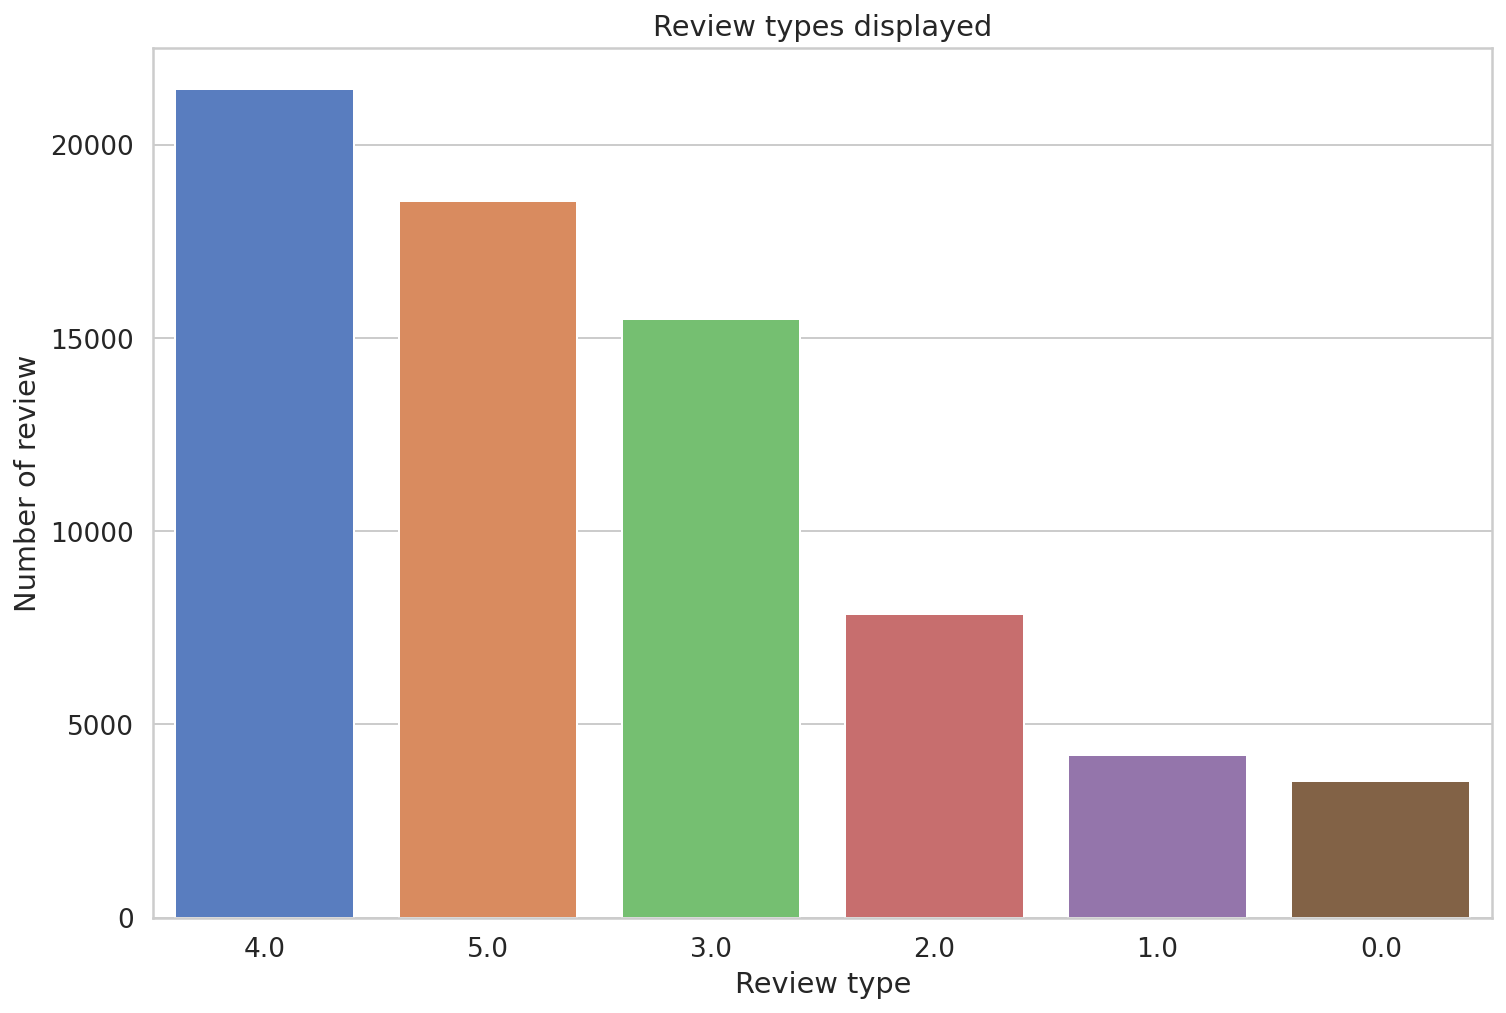

In [25]:
sns.countplot(
    x="Score",
    data=film_de,
    order=film_de.Score.value_counts().index
)

plt.xlabel("Review type")
plt.ylabel("Number of review")
plt.title("Review types displayed")

### Create an Input and Response Dataframe

- The Input dataframe contains the features that are the input for the learning and decision making of the machine learning model.
- The Response (a.k.a. Target) dataframe contains the correct expected values (a.k.a answers) that the system is suppposed to learn.

As Input I take `"Review"`

As Target I take `"Score"`

Additionally I create a new column `"Positive"` that contains labels describing how good or bad the review score is. The evaluation is done by the following criteria:
*   **"0"** up to score 1
*   **"1"** up to score 5

To achieve this, I write a function to have only positive and negative polarity using the `"Score"` column.

In [26]:
# Get review type by aforementioned method
def get_review_type(review_score):
    if review_score <= 0:
        return 0
    elif review_score >= 5:
        return 1
    else:
        return None


film_de["Positive"] = film_de["Score"].apply(
  lambda x: get_review_type(x)
)

# Combine only the useful columns
film_df_de = film_de[["Review", "Positive"]]

#### This is the dataframe after the changes:

In [27]:
film_df_de

,Review,Positive
0,Der Herr der Ringe - Die Gefährten ist für mic...,1.0
1,"Ein Ring sie zu knechten, Sie alle zu finden, ...",1.0
2,Der Herr der Ringe - Die Gefährten <> der best...,1.0
3,Was Peter Jackson hier erschaffen hat..ist ein...,1.0
4,ich habe es schon so oft gesehen ich gucke es ...,1.0
...,...,...
71124,Ein spannender Spionagethriller mit einer gut ...,NaN
71125,Will in umbedingt sehen aber er läuft wahrsche...,NaN
71126,Im Jahre 2003 war dies noch ein einfacher Fern...,NaN
71127,Typischer Videothekenmist: eine Westernstory d...,NaN


Text(0.5, 1.0, 'Review types displayed')

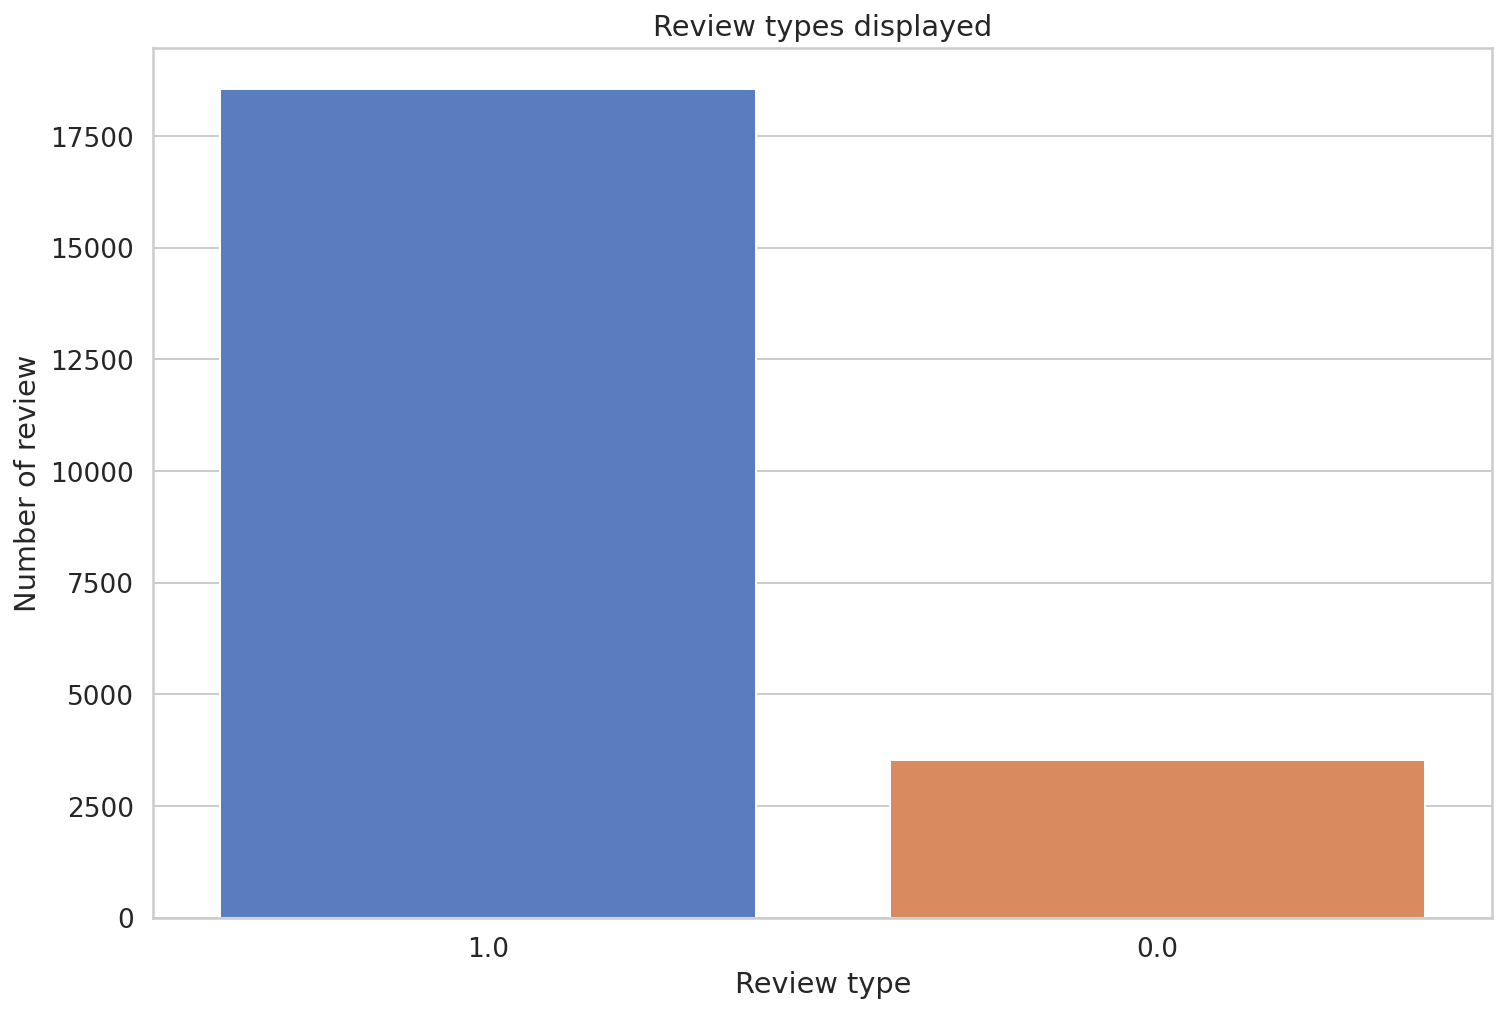

In [28]:
sns.countplot(
    x="Positive",
    data=film_df_de,
    order=film_df_de.Positive.value_counts().index
)

plt.xlabel("Review type")
plt.ylabel("Number of review")
plt.title("Review types displayed")

Now we have the two categories 1("good") and 0("bad").
As can be seen from the chart the "good" category has many more values than the "bad" category, so we should limit the larger category to the value of the smaller one.
By doing so, all categories will have an equal number of reviews.

## Resample reviews
To prepare the data for sentiment analysis, it needs to be reshaped in the way that each review type has an equal number of reviews.


In [29]:
# Get same number of reviews for each type
bad_reviews = film_df_de[film_df_de.Positive == 0]
good_reviews = film_df_de[film_df_de.Positive == 1]


sample_len = len(bad_reviews)

bad_df = bad_reviews
good_df = good_reviews.sample(n=sample_len, random_state=RANDOM_SEED)


film_review_df = good_df.append(bad_df).reset_index(drop=True)
film_review_df.shape

(7076, 2)

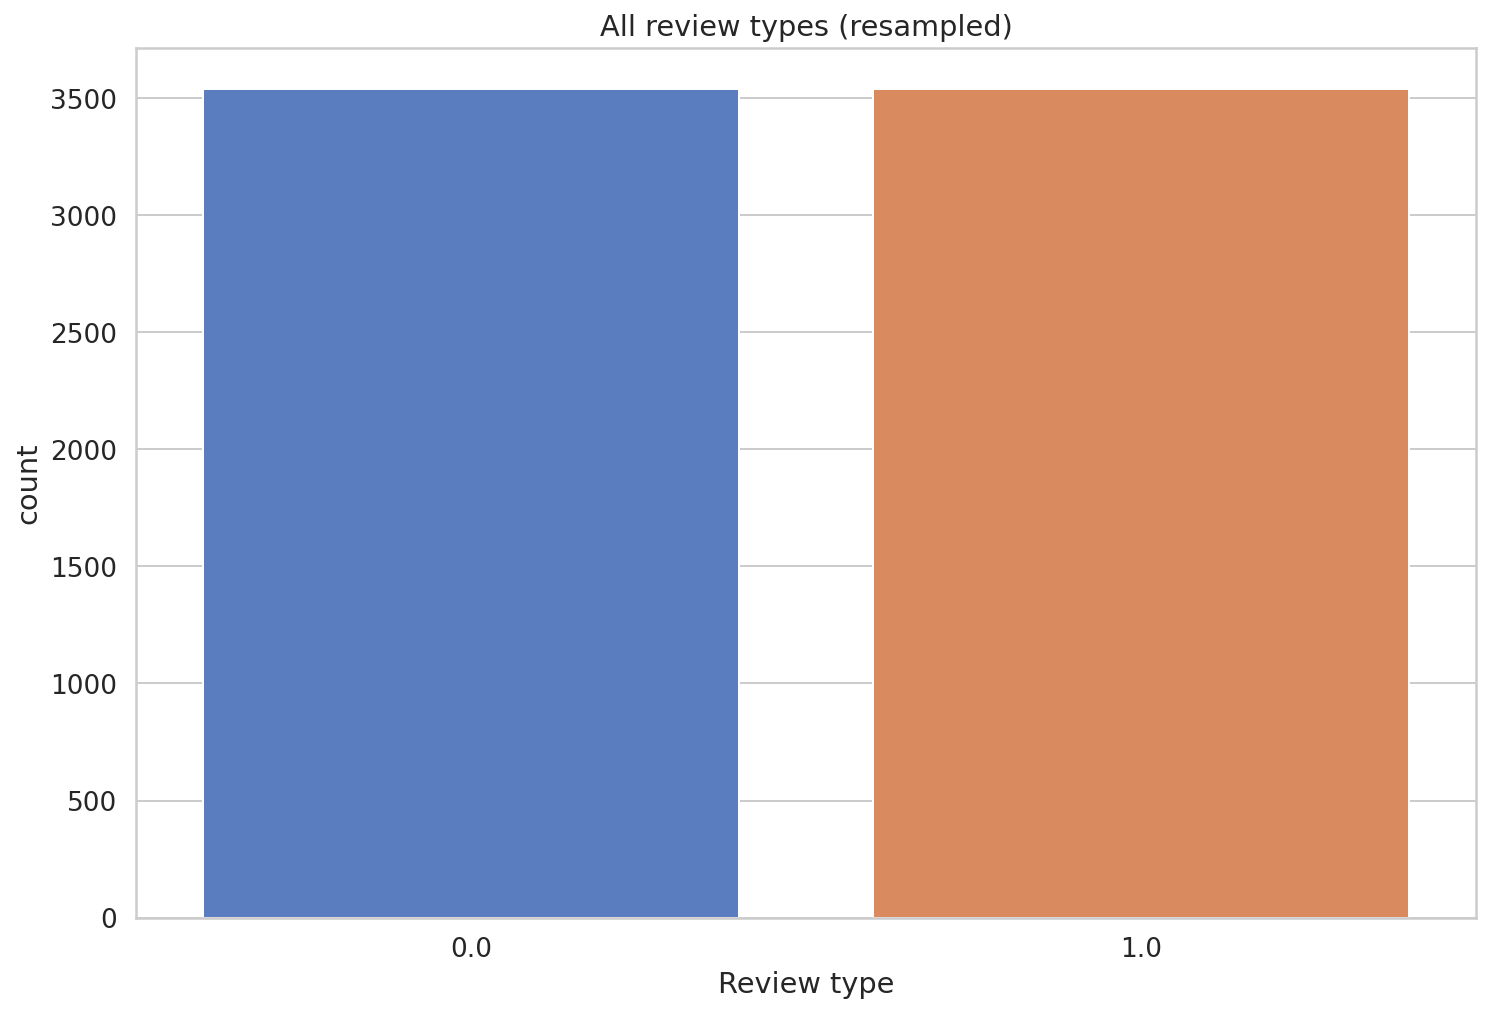

In [30]:
# Display number of each review type
sns.countplot(
  x='Positive',
  data=film_review_df,
  order=film_review_df.Positive.value_counts().index
)

plt.xlabel("Review type")
plt.title("All review types (resampled)");



------------------------------------------------------------------------------------------


# Preprocessing Filmstarts

Check the dataframe:

In [31]:
film_review_df

,Review,Positive
0,Das Dschungelbuch hat wie kein anderer Film da...,1.0
1,"Manch einer sagt vllt, schon wieder ein Comic ...",1.0
2,Völlig überraschend durch ein Sneak preview w...,1.0
3,Super Coole Fortsetzung!! Bin echt begeistert ...,1.0
4,Hi!Hab den Film schon in der USA gesehen.Der F...,1.0
...,...,...
7071,Also ich find den Film total schwachsinnig! Di...,0.0
7072,Hierbei handelt es sich um einen anti-serbisch...,0.0
7073,Auch ich habe in meinem Leben schon viele schl...,0.0
7074,Zwei Stunden Lebenszeit vergeudet. Hier wird v...,0.0


Shuffle the dataframe:

In [32]:
film_review_df = film_review_df.sample(frac=1).reset_index(drop=True)

film_review_df

,Review,Positive
0,"Ich hätte nie gedacht, dass ich einmal sowas s...",0.0
1,Großartiger Film mit tollen Schauspieler. Lars...,1.0
2,"Es fällt mir schwer, diesen Film einzustufen. ...",0.0
3,Die Euphorie um diesen Film ist mir unbegreifl...,0.0
4,Ich hasse diesen Film! Wäre er einfach nur sch...,0.0
...,...,...
7071,"Ich mache mir gerne mal Feinde ... Sicher, in...",0.0
7072,Ich habe diesen Film gebraucht gekauft und nac...,0.0
7073,SELTEN SOOOOOOOO GELANGWEILT HANDLUNG ZU LANG...,0.0
7074,Letzte Woche war ich im Kino und habe mir dies...,0.0


-----------------------------
### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
# Import ktrain along with a couple things from transformers
from transformers import AutoModel, AutoTokenizer

tokenizer_hugg = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
#model_hugg = AutoModel.from_pretrained("dbmdz/bert-base-german-cased")

In [ ]:
token_lens = []

In [ ]:
textToCheck = film_review_df.Review[1]

In [ ]:
textToCheck

In [ ]:
for txt in textToCheck:
    tokens = tokenizer_hugg.encode(txt, max_length=512)
    token_lens.append(len(tokens))

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.ylim([0, 0.005])
plt.xlabel('Token count');

----------------------------------------------------------------------------


## Prepare all what I need for the ktrain functions.
I need to define the 2 categories and train/validation set.

In [81]:
categories = ['Positive', 'Negative']

In [82]:
train, test = train_test_split(film_review_df,test_size=0.2)

In [83]:
(x_train, y_train) = (train.Review, train.Positive)
(x_test, y_test) = (test.Review, test.Positive)
 

In [88]:
x_train

5250    schipper beweist hier gekonnt, mit minimaler h...
2147    Ich denke, dass dieser Film trotz seiner gewis...
3926    Ich respektiere daß es Menschen gibt die den e...
4930    Ich kann mich der ganzen guten Kritik leider n...
3768    'The Orphan' ist meiner Meinung nach ein ('etw...
                              ...                        
1918    Solche Filme braucht kein Mensch! Eine reine T...
3831    Ist diese angesammelte Anhäuufung von Film Sch...
4474    langweilig ausgeschissen, unverdaute cyber-sch...
559     Ich habe mir diesen Film vor genau 4 Stunden a...
1675    Also ich fand den film öde und überhaupt nicht...
Name: Review, Length: 5660, dtype: object

In [89]:
y_train

5250    1.0
2147    1.0
3926    1.0
4930    0.0
3768    1.0
       ... 
1918    0.0
3831    0.0
4474    0.0
559     1.0
1675    0.0
Name: Positive, Length: 5660, dtype: float64

In [90]:
print('size of training set: %s' % (len(train['Review'])))
print('size of validation set: %s' % (len(test['Review'])))

size of training set: 5660
size of validation set: 1416


To use my sets in ktrain I have to transform them into lists first.

In [91]:
xtrain_list = x_train.values.tolist()

In [92]:
ytrain_list = y_trainst.values.tolist()

In [93]:
xtest_list = x_test.values.tolist()

In [94]:
ytest_list = y_test.values.tolist()

------------------------------------------
### List problem 

A couple of reviews were empty, so I had an error and could not process it.

AttributeError: 'float' object has no attribute 'split'

I solved this by removing all nulls.

In [108]:
test = test[test['Review'].notnull()]

In [109]:
test

,Review,Positive
1117,Vieles kann man zu dem Film nicht sagen. Die ...,1.0
6912,"Filme wie ""Alles auf Zucker"" werden leider vie...",1.0
5564,Mit dieser grandiosen Fortsetzung hat sich Jam...,1.0
1879,"Guter Ansatz, aber nur hirnloses Geprügel mit ...",0.0
2776,Während sich ''Die Träumer'' noch mit klischee...,0.0
...,...,...
2929,Schon als der Film anfing dachten ich und mein...,0.0
6168,wowwwwwwwwwwwwwwwwwwwwwwww coooooooooooooooooo...,1.0
6957,"Dieser Film ist atemberaubend, so ein toller F...",1.0
3161,"Was ein SCHROTT. Langweilig bis zum abwinken, ...",0.0


In [110]:
(x_test, y_test) = (test.Review, test.Positive)

In [111]:
xtest_list = x_test.values.tolist()

In [112]:
ytest_list = y_test.values.tolist()

--------------------------------------------------------------------
# Build a Model and Wrap in Learner
Now I put all the pieces together for ktrain, first I define the pre-trained model and the transformer.
Then I will do the preprocessing of the data.

In [53]:
MODEL_NAME = 'dbmdz/bert-base-german-cased'


In [95]:
t = text.Transformer(MODEL_NAME, maxlen=400, class_names=['0','1'])


In [96]:
trn = t.preprocess_train(xtrain_list,ytrain_list)

preprocessing train...
language: de
train sequence lengths:
	mean : 105
	95percentile : 317
	99percentile : 623


Is Multi-Label? False


In [113]:
val = t.preprocess_test(xtest_list, ytest_list)

preprocessing test...
language: de
test sequence lengths:
	mean : 111
	95percentile : 342
	99percentile : 619


In [114]:
model = t.get_classifier()


Now that I have a model I will wrap it in a ktrain learner, I will use this learner to find the best learning rate.

In [115]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=12)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
471/471 [==============================] - 178s 348ms/step - loss: 0.6653 - accuracy: 0.5643
Epoch 2/2
471/471 [==============================] - 83s 177ms/step - loss: 2.4152 - accuracy: 0.5037


done.
Visually inspect loss plot and select learning rate associated with falling loss


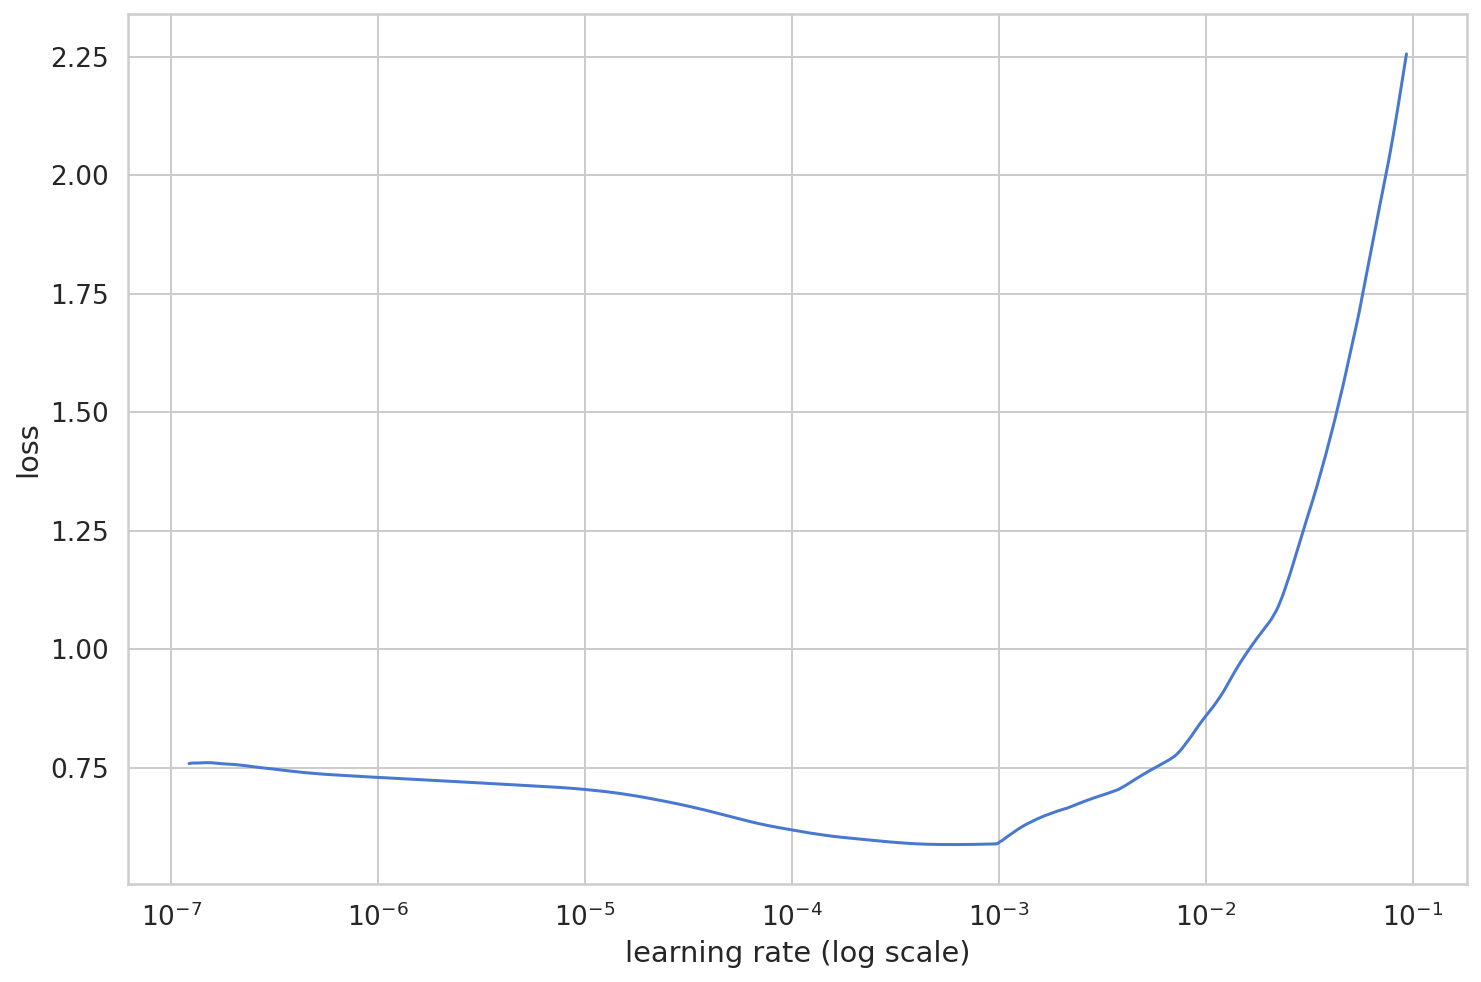

In [116]:
learner.lr_find(show_plot=True, max_epochs=2)

I chose a learning rate from -5, now I can train the model.

In [117]:
learner.autofit(3e-5, reduce_on_plateau=3, checkpoint_folder='./checkpointNewModel25.04/')

early_stopping automatically enabled at patience=5


begin training using triangular learning rate policy with max lr of 3e-05...
Epoch 1/1024
472/472 [==============================] - 190s 378ms/step - loss: 0.4936 - accuracy: 0.7200 - val_loss: 0.1846 - val_accuracy: 0.9300
Epoch 2/1024
472/472 [==============================] - 178s 375ms/step - loss: 0.1627 - accuracy: 0.9432 - val_loss: 0.1748 - val_accuracy: 0.9350
Epoch 3/1024
472/472 [==============================] - 178s 376ms/step - loss: 0.0926 - accuracy: 0.9690 - val_loss: 0.1856 - val_accuracy: 0.9350
Epoch 4/1024
472/472 [==============================] - 178s 376ms/step - loss: 0.0704 - accuracy: 0.9786 - val_loss: 0.1938 - val_accuracy: 0.9329
Epoch 5/1024
472/472 [==============================] - 178s 376ms/step - loss: 0.0549 - accuracy: 0.9835 - val_loss: 0.2332 - val_accuracy: 0.9378

Epoch 00005: Reducing Max LR on Plateau: new max lr will be 1.5e-05 (if not early_stopping).
Epoch 6/1024
472/472 [==============

In [118]:
learner.validate()

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       725
           1       0.93      0.94      0.93       690

    accuracy                           0.93      1415
   macro avg       0.93      0.94      0.93      1415
weighted avg       0.94      0.93      0.93      1415



array([[673,  52],
       [ 40, 650]])

The trained model has an accuracy of 93%.

In [ ]:
learner_de.model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_de, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

# Save the model

In [ ]:
# save model and Preprocessor instance after partially training
#ktrain.get_predictor(model_de, preproc).save('./model_save/predictor_22.04')

In [ ]:
# save model using transformers API after partially training
#learner_de.model.save('./model_save/my_model_de_22.04')

In [ ]:
# save model using transformers API after partially training
#learner_de.model.save_pretrained('./model_save/my_model_smallde_22.04')

In [186]:
print(predictor.model)
print(predictor.preproc)

Save the model using ktrain predictor, after train:

In [185]:
predictor.save('./modelsave/bertDe_predictor_93')

--------------------------------------------------------------------
# Reload Model  

In [1]:
# reload predictor
predictor = ktrain.load_predictor('./modelsave/bertDe_predictor_93')
predictor.predict('Heute ist ein schöner Tag.')

NameError: name 'ktrain' is not defined

------------------------------------------------------------------------------------------

# Make prediction

In [45]:
predictor.predict('Heute ist ein schlecte Tag.')

'0'

In [122]:
predictor.predict('Heute ist ein schöner Tag.')

'1'

In [176]:
learner.view_top_losses(n=1, preproc=t)

----------
id:553 | loss:5.71 | true:1 | pred:0)



In [178]:
print(xtest_list[553])

Habe den film bislang ca. 10 mal gesehen, ein mal in deutsch und das war echt eine enttäuschung. Die sprüche und der witz des films werden durch die deutsche synchro total zerstört! Der ganze charme kommt erst rüber wenn man auch den dialekt und den slang hört der gesprchen wird.    ps: ich finds arg übertrieben, das dieser film  bei uns indiziert ist. Es gibt andere filme die mord aus überzeugung oder auch religion ("Ausnahmezustand") beinhalten und da mault keiner rum!   Geil aber das leute tarantino als vergleich heranziehen, welcher ja ganz subtile und feine filme macht , so ganz ohne gewalt und blut und so. Für die sojakeks-esser und leute die grünen tee bevorzugen während sie einen baum umarmen. Sonderlich besser macht tarantino es jedenfalls nicht!    Die boondock saints rocken und das ohne hollywood-pr-maschine!!!


In [182]:
predictor.predict_proba(xtest_list[553])

array([0.99668026, 0.00331974], dtype=float32)

In [183]:
predictor.get_classes()

['0', '1']

In [32]:
txTest = "Philip liebte den Pferdesport – genau wie seine Enkelin Louise. Die Tochter von Prinz Edward soll nun Philips Kutsche und die zwei Lieblingsponys erben."

In [36]:
txTest2 = "Ein Brand in der südafrikanischen Metropole hat auch Flächen des berühmten Tafelbergs in Mitleidenschaft gezogen."

In [38]:
txTest3 = "Prinz Philip: Enkelin Louise bekommt seine geliebten Ponys - 20 Minuten"

In [40]:
txTest4 = "Prinz Philip: Enkelin Louise bekommt seine geliebten Ponys."

In [33]:
predictor.predict(txTest)

'1'

In [34]:
predictor.explain(txTest)

In [37]:
predictor.explain(txTest2)

In [39]:
predictor.explain(txTest3)

In [41]:
predictor.explain(txTest4)

In [43]:
predictor.explain("Eskalationsrisiko: Russland stationiert \"mehr als 150’000 Soldaten\" an der Grenze zur Ukraine. Der EU-Aussenbeauftragte Josep Borrell zeigt sich besorgt über die Lage an der ukrainischen Grenze. Russland sei mit mindestens 150’000 Soldaten aufmarschiert, es sei der grösste Aufmarsch, den es je in Russland gegeben habe.")

In [44]:
predictor.explain("Der EU-Aussenbeauftragte Josep Borrell zeigt sich besorgt über die Lage an der ukrainischen Grenze. Russland sei mit mindestens 150’000 Soldaten aufmarschiert, es sei der grösste Aufmarsch, den es je in Russland gegeben habe.")

# Save and Export Model to tensorflow lite

In [ ]:
# export TensorFlow Lite model
tflite_model_path = './tensorFlowLite/model.tflite'
tflite_model_path = predictor.export_model_to_tflite(tflite_model_path)

# load interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# set maxlen, class_names, and tokenizer (use settings employed when training the model - see above)
maxlen = 400                                                                       # from above
class_names = ['0', '1'] # from above
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-german-cased')

# preprocess and predict outside of ktrain
doc = 'Heute ist ein schöner Tag.'
inputs = tokenizer(doc, max_length=maxlen, padding='max_length', truncation=True, return_tensors="tf")
interpreter.set_tensor(input_details[0]['index'], inputs['attention_mask'])
interpreter.set_tensor(input_details[1]['index'], inputs['input_ids'])
interpreter.invoke()
output_tflite = interpreter.get_tensor(output_details[0]['index'])
print()
print('text input: %s' % (doc))
print()
print('predicted logits: %s' % (output_tflite))
print()
print("predicted class: %s" % ( class_names[np.argmax(output_tflite[0])]) )

converting to TFLite format ... this may take a few moments...


INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


done.
